In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.stats import mode
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization ,SeparableConv2D ,LeakyReLU ,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2

In [4]:
TRAIN_DIR = './train/train/'
TEST_DIR = './test/test/'
MODEL62_PATH = "model_62.h5" 
MODEL54_PATH = "model_54.h5" 

In [6]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [8]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,./train/train/fear\Training_15435534.jpg,fear
1,./train/train/neutral\Training_33464337.jpg,neutral
2,./train/train/surprise\Training_73959865.jpg,surprise
3,./train/train/sad\Training_57595951.jpg,sad
4,./train/train/angry\Training_25463356.jpg,angry


In [10]:
train.count()

image    28709
label    28709
dtype: int64

In [12]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,./test/test/angry\PrivateTest_10131363.jpg,angry
1,./test/test/angry\PrivateTest_10304478.jpg,angry
2,./test/test/angry\PrivateTest_1054527.jpg,angry
3,./test/test/angry\PrivateTest_10590091.jpg,angry
4,./test/test/angry\PrivateTest_1109992.jpg,angry


In [14]:
test.count()

image    7178
label    7178
dtype: int64

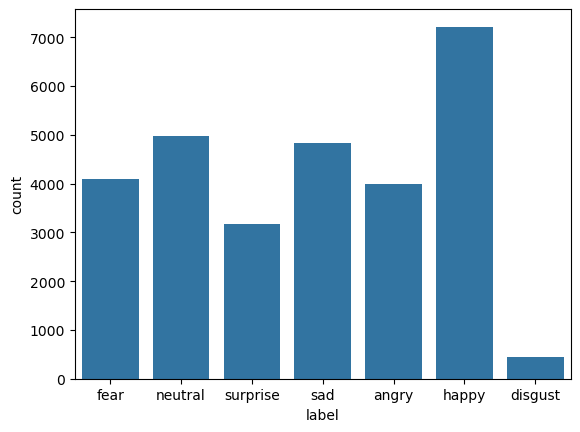

In [16]:
# sns.countplot(train['label'])
sns.countplot(x=train['label'])  # Use x=train['label'] instead of sns.countplot(train['label'])
plt.show()  # Explicitly show the plot


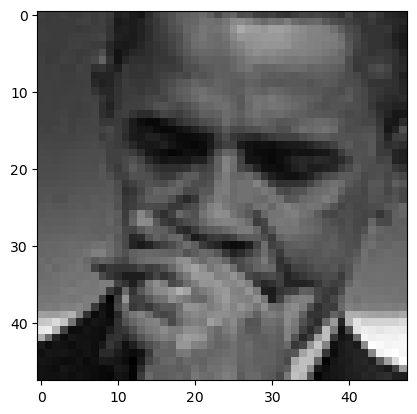

In [18]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');
plt.show()

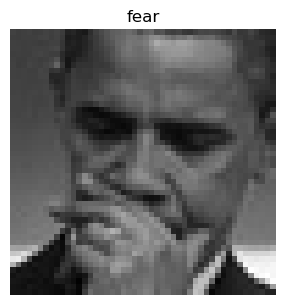

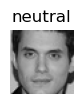

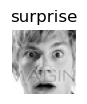

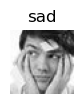

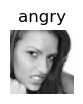

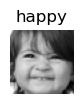

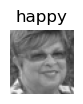

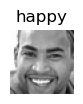

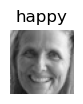

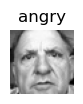

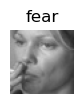

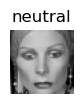

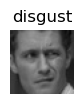

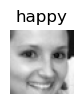

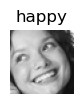

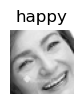

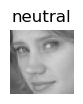

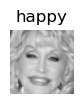

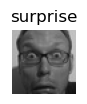

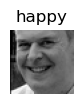

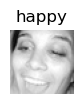

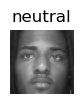

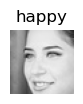

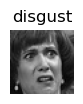

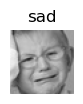

In [20]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()

In [22]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        try:
            img = load_img(image, color_mode='grayscale', target_size=(48, 48))  # Resize to ensure correct dimensions
            img = np.array(img)
            features.append(img)
        except Exception as e:
            print(f"Error loading image {image}: {e}")
            
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [24]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [26]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [28]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [30]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [32]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [34]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [36]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


In [38]:

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1)

In [40]:

input_shape = (48, 48, 1)
output_class = 7

In [42]:

if os.path.exists(MODEL62_PATH):
    print("Loading existing model...")
    model = load_model(MODEL62_PATH)
else:
    print("Creating new model...")
 
    model = Sequential()

   
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Flatten())

 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(output_class, activation='softmax'))
    
    # Compile model with RMSprop optimizer
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

Loading existing model...


In [44]:
if os.path.exists(MODEL54_PATH):
    print("Loading existing model...")
    model2 = load_model(MODEL54_PATH)
else:
    print("Creating new model...")
    model2 = Sequential()
    # convolutional layers
    model2.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.4))
    
    model2.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.4))
    
    model2.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.4))
    
    model2.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.4))
    
    model2.add(Flatten())
    # fully connected layers
    model2.add(Dense(512, activation='relu'))
    model2.add(Dropout(0.4))
    model2.add(Dense(256, activation='relu'))
    model2.add(Dropout(0.3))
    # output layer
    model2.add(Dense(output_class, activation='softmax'))
    
    model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Loading existing model...


In [52]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)



Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [64]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
# Recreate the optimizer
optimizer = RMSprop(learning_rate=0.001)
optimizer2 = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
#saving model
checkpoint = ModelCheckpoint(MODEL62_PATH, monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    validation_data=(x_test, y_test),
                    epochs=1,  
                    callbacks=[lr_reduction, checkpoint])

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5659 - loss: 1.1561  
Epoch 1: val_loss improved from inf to 1.16229, saving model to model_62.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.5659 - loss: 1.1561 - val_accuracy: 0.5708 - val_loss: 1.1623 - learning_rate: 0.0010


In [66]:

checkpoint2 = ModelCheckpoint(MODEL54_PATH, monitor='val_loss', save_best_only=True, verbose=1)

history2 = model2.fit(
    x=x_train, y=y_train,
    batch_size=128,
    epochs=1,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint2]  
)
# history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.5512 - loss: 1.1839  
Epoch 1: val_loss improved from inf to 1.10423, saving model to model_54.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 183s 811ms/step - accuracy: 0.5513 - loss: 1.1839 - val_accuracy: 0.5744 - val_loss: 1.1042


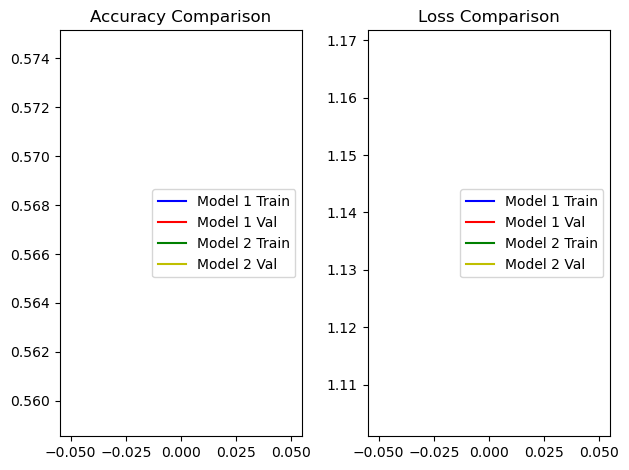

In [69]:
# plt.figure(figsize=(15,5))

# Accuracy Comparison
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'b', label='Model 1 Train')
plt.plot(history.history['val_accuracy'], 'r', label='Model 1 Val')
plt.plot(history2.history['accuracy'], 'g', label='Model 2 Train')
plt.plot(history2.history['val_accuracy'], 'y', label='Model 2 Val')
plt.title('Accuracy Comparison')
plt.legend()

# Loss Comparison
plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'b', label='Model 1 Train')
plt.plot(history.history['val_loss'], 'r', label='Model 1 Val')
plt.plot(history2.history['loss'], 'g', label='Model 2 Train')
plt.plot(history2.history['val_loss'], 'y', label='Model 2 Val')
plt.title('Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
model2 = load_model(MODEL54_PATH)
model = load_model(MODEL62_PATH)

In [73]:
model1_loss, model1_acc = model.evaluate(x_test, y_test, verbose=0)
model2_loss, model2_acc = model2.evaluate(x_test, y_test, verbose=0)

print(f"\nModel 1 Test Accuracy: {model1_acc:.2%}")
print(f"Model 2 Test Accuracy: {model2_acc:.2%}")


Model 1 Test Accuracy: 57.08%
Model 2 Test Accuracy: 57.44%


In [74]:
pred1_probs = model.predict(x_test)
pred2_probs = model2.predict(x_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step


In [77]:
# Stack predictions 
X_meta = np.hstack([pred1_probs, pred2_probs]) 
y_meta = np.argmax(y_test, axis=1)  

meta_model = LogisticRegression()
meta_model.fit(X_meta, y_meta)

stacked_predictions = meta_model.predict(X_meta)

stacked_labels = le.inverse_transform(stacked_predictions)  #

stacked_accuracy = accuracy_score(y_meta, stacked_predictions)
print(f"Stacked Model Accuracy: {stacked_accuracy:.2%}")

Stacked Model Accuracy: 60.69%


Original Output: happy
Predicted Output (Stacked model): happy


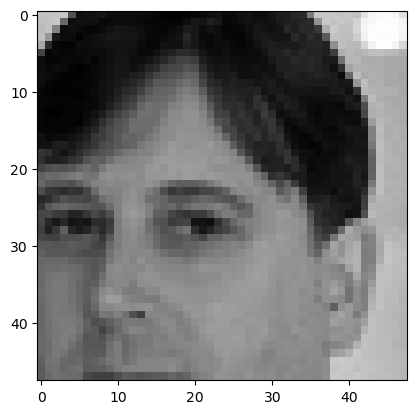

In [79]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])

print("Predicted Output (Stacked model):", stacked_labels[image_index])
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');
plt.show()

Original Output: sad
Predicted Output (Stacked model): sad


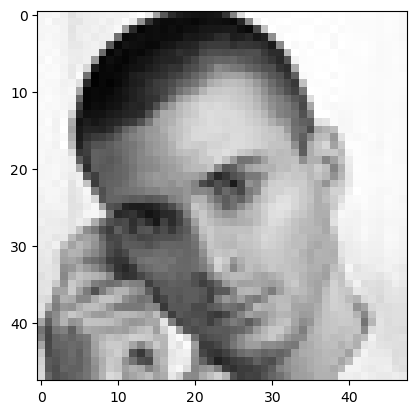

In [63]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])

print("Predicted Output (Stacked model):", stacked_labels[image_index])
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');
plt.show()